In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import torch
from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import pickle
from tqdm import tqdm

from torchvision.models import resnet18

In [23]:
save_path = 'models/resnet3.pt'
save_benchmark_path = 'models/resnet3_benchmark.pt'
save_indices_path = 'indices/resnet3_indices.pt'

load_path = save_path
load_benchmark_path = save_benchmark_path
load_indices_path = save_indices_path

LOAD_INDICES=False
TRAIN=True
COMPUTE_INFO=True

In [24]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transforms["train"])
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=data_transforms["test"])

# Print number of samples in the dataset
print(f"Number of samples in the dataset: {len(dataset)}")

Number of samples in the dataset: 50000


In [25]:
from fisherunlearn.clients_utils import split_dataset_by_class_distribution

# Compute the number of classes
num_classes = len(dataset.classes)

num_clients = 5
target_client = 0

if LOAD_INDICES:
    # Load the indices from the file
    with open(load_indices_path, 'rb') as f:
        client_indices = pickle.load(f)

    # Create subsets based on the loaded indices
    client_subsets = [torch.utils.data.Subset(dataset, indices) for indices in client_indices]

    
else:
    # Create subsets

    # Unique class distribution
    client_distributions =  np.zeros((num_clients, num_classes))
    for i in range(num_clients):
        for j in range(5):
            client_distributions[i][j] = 1/6
        client_distributions[i][5+i] = 1/6

    # Dirichlet distribution
    #alpha = 0.3
    #client_distributions = np.random.dirichlet(np.repeat(alpha, num_classes), num_clients)

    client_subsets, client_indices = split_dataset_by_class_distribution(dataset, client_distributions)

    # Save indices to a file
    # Split the base_path into the file name and extension
    base, ext = os.path.splitext(save_indices_path)
    new_path = save_indices_path
    counter = 1
    
    # Check if the file exists and update the filename if needed
    while os.path.exists(new_path):
        new_path = f"{base}({counter}){ext}"
        counter += 1

    # Save the indices to a file
    with open(new_path, 'wb') as f:
        pickle.dump(client_indices, f)


classes_distributions = np.zeros((num_classes, num_classes))
for i in range(num_classes):
    classes_distributions[i][i] = 1
    
classes_subsets,_ = split_dataset_by_class_distribution(dataset, classes_distributions)

for subset in client_subsets:
    print(f"Number of samples in the subset: {len(subset)}")

# Create dataloaders
client_dataloaders = [ DataLoader(subset, batch_size=64, shuffle=True) for subset in client_subsets]

benchmark_dataloaders = [ DataLoader(subset, batch_size=64, shuffle=True) for subset in client_subsets]
benchmark_dataloaders.pop(target_client)
target_dataloader = DataLoader(client_subsets[target_client], batch_size=64, shuffle=True)

classes_dataloaders = [ DataLoader(subset, batch_size=64, shuffle=False) for subset in classes_subsets]
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Number of samples in the subset: 6000
Number of samples in the subset: 6000
Number of samples in the subset: 6000
Number of samples in the subset: 6000
Number of samples in the subset: 6000


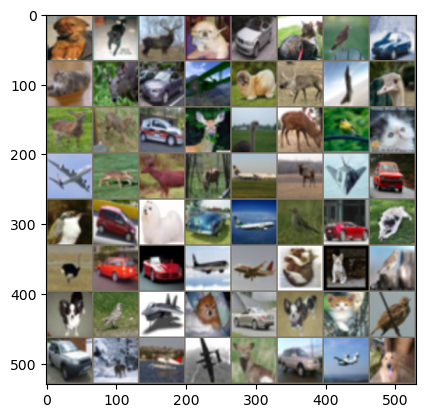

In [26]:
import torchvision
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(client_dataloaders[0]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)#, title=[classes_name[x] for x in classes])

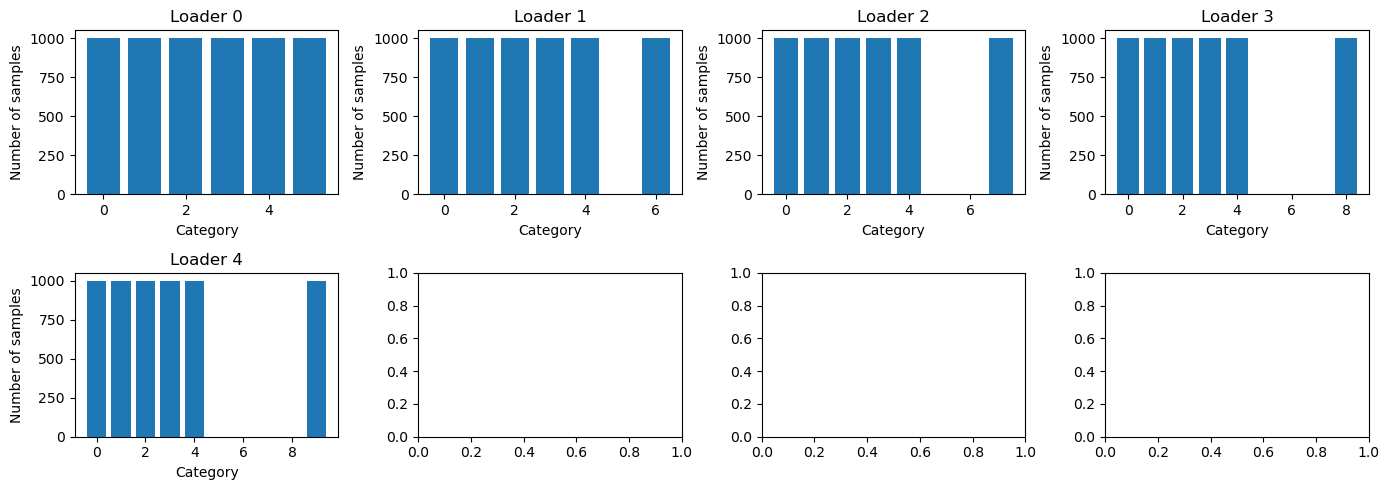

In [27]:
from collections import Counter

def get_label_distribution(dataloader):
    label_counts = Counter()
    for _, labels in dataloader:
        label_counts.update(labels.tolist())
    return dict(label_counts)

# Choose dataloader list to visualize
dataloaders = client_dataloaders

width = np.ceil(np.sqrt(2*len(dataloaders))).astype(int)
height = np.ceil(width/2).astype(int)

axs = fig, axs = plt.subplots(height, width, figsize=(14, 5))
for i, loader in enumerate(dataloaders):
    label_distribution = get_label_distribution(loader)
    axs[i//width][i%width].bar(label_distribution.keys(), label_distribution.values())
    axs[i//width][i%width].set_title(f'Loader {i}')
    axs[i//width][i%width].set_xlabel('Category')
    axs[i//width][i%width].set_ylabel('Number of samples')

plt.tight_layout()
plt.show()

In [28]:
def compute_accuracy(model, dataloader, device=None):
    if device is None:
        device_ = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device_ = device

    model.to(device_)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device_), labels.to(device_)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    if device is None:
        model.cpu()

    return correct / total

def compute_dataloaders_accuracy(model, dataloaders):
    accuracies = []
    for idx, dataloader in enumerate(dataloaders):
        accuracy = compute_accuracy(model, dataloader)
        accuracies.append(accuracy)
    return accuracies

In [40]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
def trainer(model, loss_fn, client_dataloaders, epochs, learning_rate=0.01, validation_loader=None, device=None):

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model.to(device)

    # Use SGD or Adam - Adam often requires lower initial LR
    # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0001) # Adam Example

    # Example: Use StepLR - decays LR every N epochs
    scheduler = StepLR(optimizer, step_size=10, gamma=0.05) # Decrease LR by factor of 0.1 every 10 epochs

    # Or, if using ReduceLROnPlateau, you MUST have a validation step:
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    for epoch in range(epochs):
        model.train() # Set model to training mode at the start of each epoch
        running_loss = 0.0
        total_samples = 0

        for client_loader in client_dataloaders:
            for imgs, labels in client_loader:
                imgs, labels = imgs.to(device), labels.to(device)

                # Zero gradients
                optimizer.zero_grad()

                # Forward pass
                preds = model(imgs)
                loss = loss_fn(preds, labels)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * imgs.size(0) # Accumulate loss weighted by batch size
                total_samples += imgs.size(0)

        epoch_loss = running_loss / total_samples if total_samples > 0 else 0.0
        print(f"Epoch {epoch + 1}/{epochs}, Average Training Loss: {epoch_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

        # --- Scheduler Step ---
        # If using ReduceLROnPlateau, you'd need a validation step here:
        # if validation_loader:
        #     model.eval()
        #     val_loss = 0.0
        #     val_samples = 0
        #     with torch.no_grad():
        #         for v_imgs, v_labels in validation_loader:
        #             v_imgs, v_labels = v_imgs.to(device), v_labels.to(device)
        #             v_preds = model(v_imgs)
        #             v_loss = loss_fn(v_preds, v_labels)
        #             val_loss += v_loss.item() * v_imgs.size(0)
        #             val_samples += v_imgs.size(0)
        #     avg_val_loss = val_loss / val_samples if val_samples > 0 else 0.0
        #     print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {avg_val_loss:.4f}")
        #     scheduler.step(avg_val_loss) # Step with validation loss
        # else:
        #     print("Warning: ReduceLROnPlateau scheduler used without validation_loader.")
        #     # Or handle differently if no validation loader provided

        # If using StepLR, CosineAnnealingLR, etc., call step without metric
        #scheduler.step()

    print("Training finished.")
    return model

# Save the model
def save_model_with_unique_name(model, base_path):
    # Split the base_path into the file name and extension
    base, ext = os.path.splitext(base_path)
    new_path = base_path
    counter = 1

    # Check if the file exists and update the filename if needed
    while os.path.exists(new_path):
        new_path = f"{base}({counter}){ext}"
        counter += 1

    torch.save(model.state_dict(), new_path)
    print(f"Model saved to {new_path}")

In [ ]:
# Model
model = resnet18(num_classes = 10, progress = True)
model_benchmark = resnet18(num_classes = 10)
loss_fn = nn.CrossEntropyLoss()

if TRAIN:
    model=trainer(model, loss_fn, client_dataloaders, epochs=100)
    save_model_with_unique_name(model, save_path)
    model_benchmark=trainer(model_benchmark, loss_fn, benchmark_dataloaders, epochs=100)
    save_model_with_unique_name(model_benchmark, save_benchmark_path)

else:
    model.load_state_dict(torch.load(load_path, weights_only=True))
    model_benchmark.load_state_dict(torch.load(load_benchmark_path, weights_only=True))

Using device: cuda
Epoch 1/100, Average Training Loss: 1.1941, LR: 0.001000
Epoch 2/100, Average Training Loss: 0.9508, LR: 0.001000
Epoch 3/100, Average Training Loss: 0.7951, LR: 0.001000
Epoch 4/100, Average Training Loss: 0.6876, LR: 0.001000
Epoch 5/100, Average Training Loss: 0.5863, LR: 0.001000
Epoch 6/100, Average Training Loss: 0.5042, LR: 0.001000
Epoch 7/100, Average Training Loss: 0.4247, LR: 0.001000
Epoch 8/100, Average Training Loss: 0.3613, LR: 0.001000
Epoch 9/100, Average Training Loss: 0.2946, LR: 0.001000
Epoch 10/100, Average Training Loss: 0.2526, LR: 0.001000
Epoch 11/100, Average Training Loss: 0.2071, LR: 0.001000
Epoch 12/100, Average Training Loss: 0.1772, LR: 0.001000
Epoch 13/100, Average Training Loss: 0.1576, LR: 0.001000
Epoch 14/100, Average Training Loss: 0.1460, LR: 0.001000
Epoch 15/100, Average Training Loss: 0.1298, LR: 0.001000
Epoch 16/100, Average Training Loss: 0.1368, LR: 0.001000
Epoch 17/100, Average Training Loss: 0.1249, LR: 0.001000
Epoc

In [12]:
from backpack.extensions import DiagGGNExact
from backpack import extend, backpack
import copy

def compute_diag_hessian(model, criterion, inputs, targets, device='cpu'):
    inputs = inputs.to(device)
    targets = targets.to(device)

    model.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    with backpack(DiagGGNExact()):
        loss.backward()

    diag_hessian_params = {}
    for name, param in model.named_parameters():
        if hasattr(param, 'diag_ggn_exact') and param.requires_grad:
            diag_hessian_params[name] = param.diag_ggn_exact.clone().detach()
            # Cleanup to avoid leftover references
            del param.diag_ggn_exact

    return diag_hessian_params

def compute_informations(model, criterion, dataloader_list):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = copy.deepcopy(model).to(device).eval()
    criterion = copy.deepcopy(criterion).to(device)
    model = extend(model, use_converter=True)
    criterion = extend(criterion)

    num_clients = len(dataloader_list)
    clients_hessians = []

    num_batches = sum(len(loader) for loader in dataloader_list)
    tqdm_bar = tqdm(total=num_batches, desc="Computing clients information", unit="batch")    

    for loader in dataloader_list:
        client_hessian = {}
        for inputs, targets in loader:
            # Compute the diag Hessian for this batch
            diag_h = compute_diag_hessian(model, criterion, inputs, targets, device=device)

            # Accumulate avarage over batches
            for name, value in diag_h.items():
                if name not in client_hessian:
                    client_hessian[name] = value/(len(loader)*num_clients)
                else:
                    client_hessian[name] += value/(len(loader)*num_clients)
            tqdm_bar.update(1)

        clients_hessians.append(client_hessian)
    
    tqdm_bar.close()

    total_hessian = {}
    for name in clients_hessians[0].keys():
        total_hessian[name] = sum(client_hessian[name] for client_hessian in clients_hessians)

    
    clients_informations = []
    for client_idx in range(num_clients):
        client_info = {}
        for name in clients_hessians[client_idx].keys():
            layer_info = 0.5 * torch.pow(clients_hessians[client_idx][name]/total_hessian[name], 2)
            layer_info[total_hessian[name] == 0] = 0
            client_info[name] = layer_info.detach().cpu()
        clients_informations.append(client_info)
    
    return clients_informations


In [13]:
#from fisherunlearn import compute_informations

if COMPUTE_INFO:

    informations = compute_informations(model, loss_fn, client_dataloaders)

    with open('cached/informations.pkl', 'wb') as f:
            pickle.dump(informations, f)
else:
    with open('cached/informations.pkl', 'rb') as f:
        informations = pickle.load(f)

Computing clients information: 100%|██████████| 360/360 [7:30:35<00:00, 75.10s/batch]  


In [14]:
from fisherunlearn import find_informative_params, reset_parameters

info=informations[target_client]

whitelist = []
for name in info.keys():
    if "weight" in name:
        whitelist.append(name)

informative_params = find_informative_params(info, method='information', percentage=7, whitelist=whitelist, graph=False)

for name, params in informative_params.items():
    print(f"Layer: {name}, Parameters: {params.shape}")  # Print first 5 values for brevity
    

resetted_model = resnet18(num_classes = 10)

resetted_model.load_state_dict(reset_parameters(model, informative_params), strict=False)


Layer: conv1.weight, Parameters: torch.Size([405, 4])
Layer: bn1.weight, Parameters: torch.Size([1, 1])
Layer: layer1.0.conv1.weight, Parameters: torch.Size([350, 4])
Layer: layer1.0.bn1.weight, Parameters: torch.Size([1, 1])
Layer: layer1.0.conv2.weight, Parameters: torch.Size([207, 4])
Layer: layer1.0.bn2.weight, Parameters: torch.Size([1, 1])
Layer: layer1.1.conv1.weight, Parameters: torch.Size([86, 4])
Layer: layer1.1.bn1.weight, Parameters: torch.Size([0, 1])
Layer: layer1.1.conv2.weight, Parameters: torch.Size([87, 4])
Layer: layer1.1.bn2.weight, Parameters: torch.Size([2, 1])
Layer: layer2.0.conv1.weight, Parameters: torch.Size([260, 4])
Layer: layer2.0.bn1.weight, Parameters: torch.Size([3, 1])
Layer: layer2.0.conv2.weight, Parameters: torch.Size([569, 4])
Layer: layer2.0.bn2.weight, Parameters: torch.Size([2, 1])
Layer: layer2.0.downsample.0.weight, Parameters: torch.Size([36, 4])
Layer: layer2.0.downsample.1.weight, Parameters: torch.Size([2, 1])
Layer: layer2.1.conv1.weight,

<All keys matched successfully>

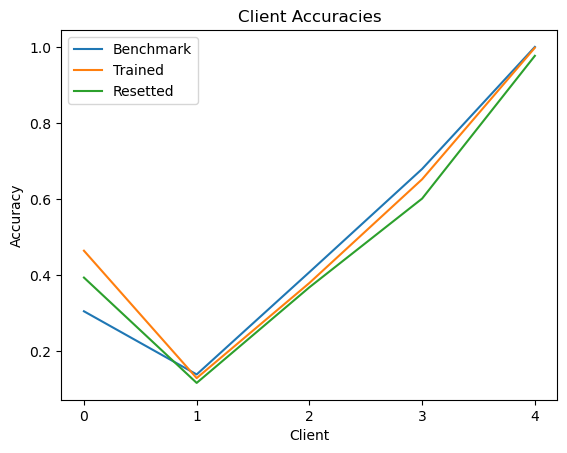

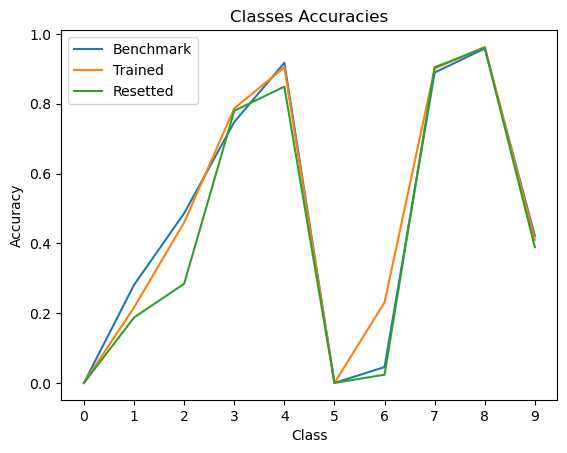

In [15]:

plt.plot(compute_dataloaders_accuracy(model_benchmark, client_dataloaders), label='Benchmark')
plt.plot(compute_dataloaders_accuracy(model, client_dataloaders), label='Trained')
plt.plot(compute_dataloaders_accuracy(resetted_model, client_dataloaders), label='Resetted')
plt.legend()
plt.xlabel('Client')
plt.xticks(np.arange(0, 5, 1))
plt.ylabel('Accuracy')
plt.title('Client Accuracies')
plt.show()

plt.plot(compute_dataloaders_accuracy(model_benchmark, classes_dataloaders), label='Benchmark')
plt.plot(compute_dataloaders_accuracy(model, classes_dataloaders), label='Trained')
plt.plot(compute_dataloaders_accuracy(resetted_model, classes_dataloaders), label='Resetted')
plt.legend()
plt.xlabel('Class')
plt.xticks(np.arange(0, 10, 1))
plt.ylabel('Accuracy')
plt.title('Classes Accuracies')
plt.show()


In [16]:
print("Benchmark model test accuracy:")
print(compute_accuracy(model_benchmark, test_dataloader))
print("Trained model test accuracy:")
print(compute_accuracy(model, test_dataloader))
print("Resetted model test accuracy:")
print(compute_accuracy(resetted_model, test_dataloader))
print("Benchmark model target client accuracy:")
print(compute_accuracy(model_benchmark, target_dataloader))
print("Trained model target client accuracy:")
print(compute_accuracy(model, target_dataloader))
print("Resetted model target client accuracy:")
print(compute_accuracy(resetted_model, target_dataloader))

Benchmark model test accuracy:
0.4163
Trained model test accuracy:
0.4193
Resetted model test accuracy:
0.3799
Benchmark model target client accuracy:
0.30489938757655294
Trained model target client accuracy:
0.4641294838145232
Resetted model target client accuracy:
0.3934820647419073


Calculating benchmark accuracies (retrained_model)...
  Benchmark Global Test Accuracy: 0.4163
  Benchmark Target Client Accuracy: 0.3049


Processing Percentages:   0%|          | 0/21 [00:00<?, ?it/s]


Evaluating unlearning for different parameter percentages...

--- Processing Percentage: 0% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.4193
  Reset-Only Target Client Accuracy: 0.4641
  Delta Test Acc (Reset - Benchmark): 0.0030
  Delta Target Acc (Reset - Benchmark): 0.1592
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 0.0332, LR: 0.001000
Training finished.


Processing Percentages:   5%|▍         | 1/21 [00:24<08:03, 24.16s/it]

  Retrained-from-Reset Global Test Accuracy: 0.4261
  Retrained-from-Reset Target Client Accuracy: 0.4880
  Delta Test Acc (Retrained - Benchmark): 0.0098
  Delta Target Acc (Retrained - Benchmark): 0.1831

--- Processing Percentage: 5% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.3986
  Reset-Only Target Client Accuracy: 0.4283
  Delta Test Acc (Reset - Benchmark): -0.0177
  Delta Target Acc (Reset - Benchmark): 0.1234
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 0.0341, LR: 0.001000
Training finished.


Processing Percentages:  10%|▉         | 2/21 [00:48<07:37, 24.06s/it]

  Retrained-from-Reset Global Test Accuracy: 0.4117
  Retrained-from-Reset Target Client Accuracy: 0.4477
  Delta Test Acc (Retrained - Benchmark): -0.0046
  Delta Target Acc (Retrained - Benchmark): 0.1428

--- Processing Percentage: 10% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.3751
  Reset-Only Target Client Accuracy: 0.3856
  Delta Test Acc (Reset - Benchmark): -0.0412
  Delta Target Acc (Reset - Benchmark): 0.0807
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 0.0478, LR: 0.001000
Training finished.


Processing Percentages:  14%|█▍        | 3/21 [01:12<07:11, 23.99s/it]

  Retrained-from-Reset Global Test Accuracy: 0.4046
  Retrained-from-Reset Target Client Accuracy: 0.4259
  Delta Test Acc (Retrained - Benchmark): -0.0117
  Delta Target Acc (Retrained - Benchmark): 0.1210

--- Processing Percentage: 15% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.3414
  Reset-Only Target Client Accuracy: 0.3517
  Delta Test Acc (Reset - Benchmark): -0.0749
  Delta Target Acc (Reset - Benchmark): 0.0468
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 0.0763, LR: 0.001000
Training finished.


Processing Percentages:  19%|█▉        | 4/21 [01:35<06:47, 23.96s/it]

  Retrained-from-Reset Global Test Accuracy: 0.4161
  Retrained-from-Reset Target Client Accuracy: 0.4020
  Delta Test Acc (Retrained - Benchmark): -0.0002
  Delta Target Acc (Retrained - Benchmark): 0.0971

--- Processing Percentage: 20% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.2651
  Reset-Only Target Client Accuracy: 0.2498
  Delta Test Acc (Reset - Benchmark): -0.1512
  Delta Target Acc (Reset - Benchmark): -0.0551
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 0.1612, LR: 0.001000
Training finished.


Processing Percentages:  24%|██▍       | 5/21 [01:59<06:22, 23.94s/it]

  Retrained-from-Reset Global Test Accuracy: 0.3890
  Retrained-from-Reset Target Client Accuracy: 0.3712
  Delta Test Acc (Retrained - Benchmark): -0.0273
  Delta Target Acc (Retrained - Benchmark): 0.0663

--- Processing Percentage: 25% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.2359
  Reset-Only Target Client Accuracy: 0.2281
  Delta Test Acc (Reset - Benchmark): -0.1804
  Delta Target Acc (Reset - Benchmark): -0.0768
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 0.2264, LR: 0.001000
Training finished.


Processing Percentages:  29%|██▊       | 6/21 [02:23<05:59, 23.96s/it]

  Retrained-from-Reset Global Test Accuracy: 0.4027
  Retrained-from-Reset Target Client Accuracy: 0.3742
  Delta Test Acc (Retrained - Benchmark): -0.0136
  Delta Target Acc (Retrained - Benchmark): 0.0693

--- Processing Percentage: 30% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.2009
  Reset-Only Target Client Accuracy: 0.2216
  Delta Test Acc (Reset - Benchmark): -0.2154
  Delta Target Acc (Reset - Benchmark): -0.0833
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 0.3100, LR: 0.001000
Training finished.


Processing Percentages:  33%|███▎      | 7/21 [02:47<05:34, 23.91s/it]

  Retrained-from-Reset Global Test Accuracy: 0.3817
  Retrained-from-Reset Target Client Accuracy: 0.3441
  Delta Test Acc (Retrained - Benchmark): -0.0346
  Delta Target Acc (Retrained - Benchmark): 0.0392

--- Processing Percentage: 35% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.2077
  Reset-Only Target Client Accuracy: 0.2157
  Delta Test Acc (Reset - Benchmark): -0.2086
  Delta Target Acc (Reset - Benchmark): -0.0892
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 0.4478, LR: 0.001000
Training finished.


Processing Percentages:  38%|███▊      | 8/21 [03:11<05:10, 23.92s/it]

  Retrained-from-Reset Global Test Accuracy: 0.4028
  Retrained-from-Reset Target Client Accuracy: 0.3565
  Delta Test Acc (Retrained - Benchmark): -0.0135
  Delta Target Acc (Retrained - Benchmark): 0.0516

--- Processing Percentage: 40% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.1505
  Reset-Only Target Client Accuracy: 0.2181
  Delta Test Acc (Reset - Benchmark): -0.2658
  Delta Target Acc (Reset - Benchmark): -0.0868
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 0.5887, LR: 0.001000
Training finished.


Processing Percentages:  43%|████▎     | 9/21 [03:35<04:46, 23.91s/it]

  Retrained-from-Reset Global Test Accuracy: 0.3785
  Retrained-from-Reset Target Client Accuracy: 0.3283
  Delta Test Acc (Retrained - Benchmark): -0.0378
  Delta Target Acc (Retrained - Benchmark): 0.0234

--- Processing Percentage: 45% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.1429
  Reset-Only Target Client Accuracy: 0.1255
  Delta Test Acc (Reset - Benchmark): -0.2734
  Delta Target Acc (Reset - Benchmark): -0.1794
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 0.7163, LR: 0.001000
Training finished.


Processing Percentages:  48%|████▊     | 10/21 [03:59<04:23, 23.92s/it]

  Retrained-from-Reset Global Test Accuracy: 0.3669
  Retrained-from-Reset Target Client Accuracy: 0.3082
  Delta Test Acc (Retrained - Benchmark): -0.0494
  Delta Target Acc (Retrained - Benchmark): 0.0033

--- Processing Percentage: 50% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.1734
  Reset-Only Target Client Accuracy: 0.1868
  Delta Test Acc (Reset - Benchmark): -0.2429
  Delta Target Acc (Reset - Benchmark): -0.1181
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 0.8309, LR: 0.001000
Training finished.


Processing Percentages:  52%|█████▏    | 11/21 [04:23<03:59, 23.91s/it]

  Retrained-from-Reset Global Test Accuracy: 0.3495
  Retrained-from-Reset Target Client Accuracy: 0.3126
  Delta Test Acc (Retrained - Benchmark): -0.0668
  Delta Target Acc (Retrained - Benchmark): 0.0077

--- Processing Percentage: 55% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.1623
  Reset-Only Target Client Accuracy: 0.1096
  Delta Test Acc (Reset - Benchmark): -0.2540
  Delta Target Acc (Reset - Benchmark): -0.1953
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 0.9546, LR: 0.001000
Training finished.


Processing Percentages:  57%|█████▋    | 12/21 [04:47<03:35, 23.90s/it]

  Retrained-from-Reset Global Test Accuracy: 0.3273
  Retrained-from-Reset Target Client Accuracy: 0.2793
  Delta Test Acc (Retrained - Benchmark): -0.0890
  Delta Target Acc (Retrained - Benchmark): -0.0256

--- Processing Percentage: 60% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.1449
  Reset-Only Target Client Accuracy: 0.2434
  Delta Test Acc (Reset - Benchmark): -0.2714
  Delta Target Acc (Reset - Benchmark): -0.0615
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 1.0503, LR: 0.001000
Training finished.


Processing Percentages:  62%|██████▏   | 13/21 [05:11<03:10, 23.87s/it]

  Retrained-from-Reset Global Test Accuracy: 0.3029
  Retrained-from-Reset Target Client Accuracy: 0.2636
  Delta Test Acc (Retrained - Benchmark): -0.1134
  Delta Target Acc (Retrained - Benchmark): -0.0413

--- Processing Percentage: 65% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.1399
  Reset-Only Target Client Accuracy: 0.2620
  Delta Test Acc (Reset - Benchmark): -0.2764
  Delta Target Acc (Reset - Benchmark): -0.0429
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 1.1584, LR: 0.001000
Training finished.


Processing Percentages:  67%|██████▋   | 14/21 [05:34<02:46, 23.83s/it]

  Retrained-from-Reset Global Test Accuracy: 0.2748
  Retrained-from-Reset Target Client Accuracy: 0.2601
  Delta Test Acc (Retrained - Benchmark): -0.1415
  Delta Target Acc (Retrained - Benchmark): -0.0448

--- Processing Percentage: 70% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.0993
  Reset-Only Target Client Accuracy: 0.2211
  Delta Test Acc (Reset - Benchmark): -0.3170
  Delta Target Acc (Reset - Benchmark): -0.0838
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 1.1825, LR: 0.001000
Training finished.


Processing Percentages:  71%|███████▏  | 15/21 [05:58<02:22, 23.78s/it]

  Retrained-from-Reset Global Test Accuracy: 0.2708
  Retrained-from-Reset Target Client Accuracy: 0.2780
  Delta Test Acc (Retrained - Benchmark): -0.1455
  Delta Target Acc (Retrained - Benchmark): -0.0269

--- Processing Percentage: 75% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.0975
  Reset-Only Target Client Accuracy: 0.1126
  Delta Test Acc (Reset - Benchmark): -0.3188
  Delta Target Acc (Reset - Benchmark): -0.1923
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 1.2100, LR: 0.001000
Training finished.


Processing Percentages:  76%|███████▌  | 16/21 [06:22<01:58, 23.77s/it]

  Retrained-from-Reset Global Test Accuracy: 0.2722
  Retrained-from-Reset Target Client Accuracy: 0.2662
  Delta Test Acc (Retrained - Benchmark): -0.1441
  Delta Target Acc (Retrained - Benchmark): -0.0387

--- Processing Percentage: 80% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.1000
  Reset-Only Target Client Accuracy: 0.1732
  Delta Test Acc (Reset - Benchmark): -0.3163
  Delta Target Acc (Reset - Benchmark): -0.1317
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 1.2842, LR: 0.001000
Training finished.


Processing Percentages:  81%|████████  | 17/21 [06:46<01:35, 23.79s/it]

  Retrained-from-Reset Global Test Accuracy: 0.2635
  Retrained-from-Reset Target Client Accuracy: 0.2467
  Delta Test Acc (Retrained - Benchmark): -0.1528
  Delta Target Acc (Retrained - Benchmark): -0.0582

--- Processing Percentage: 85% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.1000
  Reset-Only Target Client Accuracy: 0.1737
  Delta Test Acc (Reset - Benchmark): -0.3163
  Delta Target Acc (Reset - Benchmark): -0.1312
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 1.2990, LR: 0.001000
Training finished.


Processing Percentages:  86%|████████▌ | 18/21 [07:09<01:11, 23.82s/it]

  Retrained-from-Reset Global Test Accuracy: 0.2500
  Retrained-from-Reset Target Client Accuracy: 0.2058
  Delta Test Acc (Retrained - Benchmark): -0.1663
  Delta Target Acc (Retrained - Benchmark): -0.0991

--- Processing Percentage: 90% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.1035
  Reset-Only Target Client Accuracy: 0.2640
  Delta Test Acc (Reset - Benchmark): -0.3128
  Delta Target Acc (Reset - Benchmark): -0.0409
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 1.2839, LR: 0.001000
Training finished.


Processing Percentages:  90%|█████████ | 19/21 [07:33<00:47, 23.80s/it]

  Retrained-from-Reset Global Test Accuracy: 0.2266
  Retrained-from-Reset Target Client Accuracy: 0.1964
  Delta Test Acc (Retrained - Benchmark): -0.1897
  Delta Target Acc (Retrained - Benchmark): -0.1085

--- Processing Percentage: 95% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.1000
  Reset-Only Target Client Accuracy: 0.2257
  Delta Test Acc (Reset - Benchmark): -0.3163
  Delta Target Acc (Reset - Benchmark): -0.0792
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 1.5008, LR: 0.001000
Training finished.


Processing Percentages:  95%|█████████▌| 20/21 [07:57<00:23, 23.80s/it]

  Retrained-from-Reset Global Test Accuracy: 0.2147
  Retrained-from-Reset Target Client Accuracy: 0.1737
  Delta Test Acc (Retrained - Benchmark): -0.2016
  Delta Target Acc (Retrained - Benchmark): -0.1312

--- Processing Percentage: 100% ---
  Found 62 informative parameter names.
  Reset-Only Global Test Accuracy: 0.1000
  Reset-Only Target Client Accuracy: 0.2929
  Delta Test Acc (Reset - Benchmark): -0.3163
  Delta Target Acc (Reset - Benchmark): -0.0120
  Retraining from reset for 1 epoch(s)...
Using device: cuda
Epoch 1/1, Average Training Loss: 1.9483, LR: 0.001000
Training finished.


Processing Percentages: 100%|██████████| 21/21 [08:21<00:00, 23.87s/it]

  Retrained-from-Reset Global Test Accuracy: 0.1000
  Retrained-from-Reset Target Client Accuracy: 0.0070
  Delta Test Acc (Retrained - Benchmark): -0.3163
  Delta Target Acc (Retrained - Benchmark): -0.2979

Plotting results...


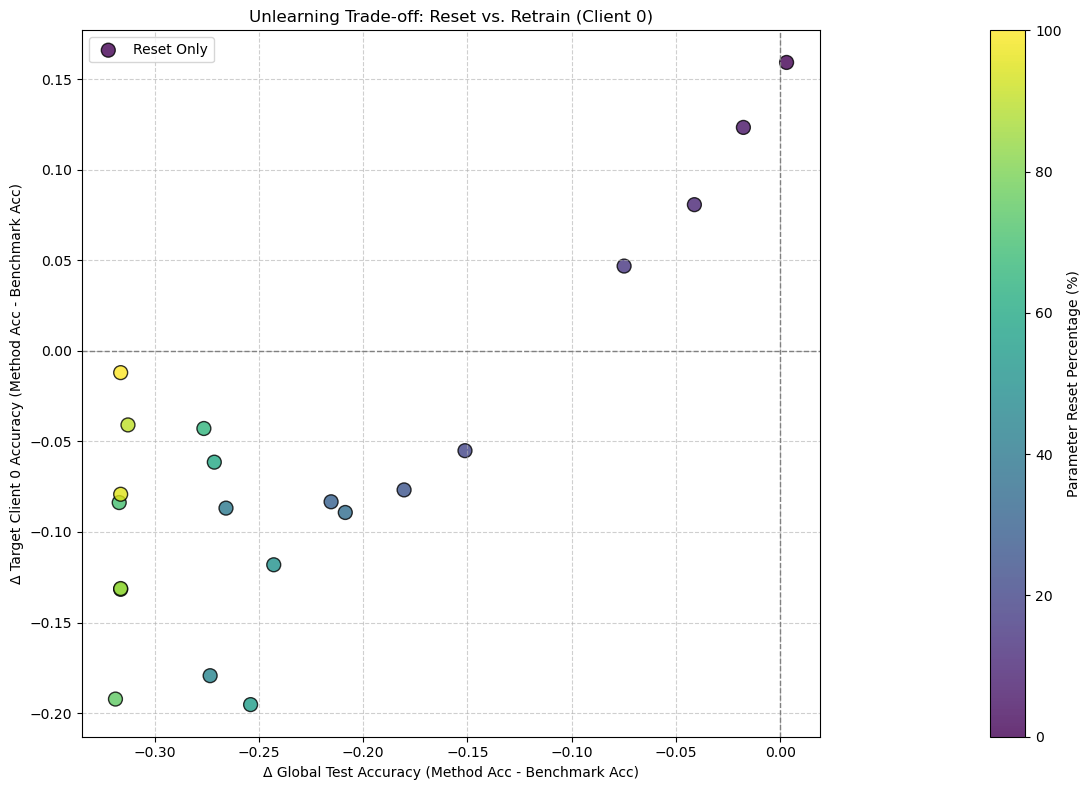


Computed Deltas:
{'delta_test_accuracies_reset': [0.0030000000000000027, -0.017699999999999994, -0.041200000000000014, -0.07490000000000002, -0.1512, -0.1804, -0.2154, -0.2086, -0.26580000000000004, -0.2734, -0.2429, -0.254, -0.2714, -0.2764, -0.317, -0.3188, -0.3163, -0.3163, -0.3128, -0.3163, -0.3163], 'delta_target_accuracies_reset': [0.15923009623797024, 0.12335958005249342, 0.0807086614173228, 0.04680664916885391, -0.055118110236220486, -0.07677165354330709, -0.08333333333333334, -0.08923884514435695, -0.08683289588801402, -0.1793525809273841, -0.11811023622047245, -0.1953193350831146, -0.06146106736657919, -0.04286964129483817, -0.08377077865266844, -0.19225721784776903, -0.13167104111986003, -0.13123359580052493, -0.0409011373578303, -0.07917760279965005, -0.01202974628171477], 'delta_test_accuracies_retrained': [0.009799999999999975, -0.004599999999999993, -0.011699999999999988, -0.00019999999999997797, -0.02729999999999999, -0.013600000000000001, -0.03460000000000002, -0.0135

In [20]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
from typing import Callable, Dict, List, Optional, Any, Union

class UnlearningTradeoffPlotter:
    """
    Computes and plots the unlearning trade-off graph.

    Compares the drop in accuracy on a global test set vs. the drop in accuracy
    on the target client's data for various parameter reset percentages. Plots results
    for both the reset-only model and a model retrained after resetting. Deltas
    are calculated relative to a benchmark 'retrained_model'.
    """
    def __init__(
        self,
        # Models & Data
        original_model: torch.nn.Module,
        retrained_model: torch.nn.Module, # Benchmark model (e.g., model_benchmark)
        informations: Dict[Any, Dict[str, torch.Tensor]],
        target_client: Any,
        target_client_dataloader: torch.utils.data.DataLoader,
        global_test_dataloader: torch.utils.data.DataLoader,
        benchmark_dataloaders: List[torch.utils.data.DataLoader], # DataLoaders excluding target_client

        # Core Functions & Model Arch
        model_architecture_fn: Callable[..., torch.nn.Module],
        model_init_args: Dict[str, Any],
        find_informative_params_fn: Callable[..., List[str]],
        reset_parameters_fn: Callable[..., Dict[str, torch.Tensor]],
        compute_accuracy_fn: Callable[..., float],
        trainer_fn: Callable[..., torch.nn.Module], # Your trainer function
        loss_fn_retrain: nn.Module, # Loss function for retraining step

        # Configuration
        epochs_retrain: int = 1, # Epochs for retraining after reset
        device: Optional[Union[str, torch.device]] = None,
        verbose: bool = True
    ):
        """
        Initializes the plotter with models, data, and functions.
        """
        self.original_model = original_model.cpu() # Keep original on CPU
        self.retrained_model = retrained_model
        self.informations = informations
        self.target_client = target_client
        self.target_client_dataloader = target_client_dataloader
        self.global_test_dataloader = global_test_dataloader
        self.benchmark_dataloaders = benchmark_dataloaders # Data for retraining

        self.model_architecture_fn = model_architecture_fn
        self.model_init_args = model_init_args
        self.find_informative_params_fn = find_informative_params_fn
        self.reset_parameters_fn = reset_parameters_fn
        self.compute_accuracy_fn = compute_accuracy_fn
        self.trainer_fn = trainer_fn # Store trainer function
        self.loss_fn_retrain = loss_fn_retrain # Store loss for retraining
        self.epochs_retrain = epochs_retrain # Store epochs for retraining

        self.verbose = verbose

        if device is None:
            self._device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self._device = torch.device(device)

        # Results storage
        self.delta_test_accuracies_reset: List[float] = []
        self.delta_target_accuracies_reset: List[float] = []
        self.delta_test_accuracies_retrained: List[float] = []
        self.delta_target_accuracies_retrained: List[float] = []
        self.param_percentages_tested: Optional[np.ndarray] = None

        # Calculate benchmark accuracies once
        self._calculate_benchmark_accuracies()

    def _calculate_benchmark_accuracies(self):
        """Computes and stores benchmark accuracies."""
        if self.verbose: print("Calculating benchmark accuracies (retrained_model)...")
        self.retrained_model.to(self._device)
        self.retrained_test_acc = self.compute_accuracy_fn(
            self.retrained_model, self.global_test_dataloader, device=self._device
        )
        self.retrained_target_acc = self.compute_accuracy_fn(
            self.retrained_model, self.target_client_dataloader, device=self._device
        )
        # Optional: Move back to CPU
        # self.retrained_model.cpu()
        if self.verbose:
            print(f"  Benchmark Global Test Accuracy: {self.retrained_test_acc:.4f}")
            print(f"  Benchmark Target Client Accuracy: {self.retrained_target_acc:.4f}")

    # In class UnlearningTradeoffPlotter:

    def compute_deltas(
        self,
        param_percentages: Optional[Union[List[float], np.ndarray]] = None
    ) -> Dict[str, List[float]]:
        """
        Computes the accuracy deltas (Unlearned Acc - Benchmark Acc) for the
        specified percentages for both reset-only and retrained-from-reset models.

        Args:
            param_percentages: List/array of percentages (0-100). Defaults to [0, 10,..., 100].

        Returns:
            Dictionary containing the computed deltas and percentages.
        """
        if param_percentages is None:
            self.param_percentages_tested = np.linspace(0, 100, 11).astype(int)
        else:
            self.param_percentages_tested = np.array(param_percentages)

        # Reset results lists
        self.delta_test_accuracies_reset = []
        self.delta_target_accuracies_reset = []
        self.delta_test_accuracies_retrained = []
        self.delta_target_accuracies_retrained = []

        try:
            info = self.informations[self.target_client]
        except KeyError:
            raise ValueError(f"Target client '{self.target_client}' not found in informations dict.")

        iterator = tqdm(self.param_percentages_tested, desc="Processing Percentages") if self.verbose else self.param_percentages_tested
        if self.verbose: print("\nEvaluating unlearning for different parameter percentages...")

        for perc in iterator:
            if self.verbose: print(f"\n--- Processing Percentage: {perc}% ---")

            resetted_model = None
            retrained_from_reset_model = None

            try:
                # --- Reset Step ---
                informative_params = self.find_informative_params_fn(
                    info, method='information', percentage=perc, graph=False
                )
                if self.verbose: print(f"  Found {len(informative_params)} informative parameter names.")
                
                resetted_model = self.model_architecture_fn(**self.model_init_args)
                resetted_state_dict = self.reset_parameters_fn(self.original_model, informative_params)
                resetted_model.load_state_dict(resetted_state_dict, strict=True)
                resetted_model.to(self._device)


                # Evaluate Reset-Only Model
                reset_test_acc = self.compute_accuracy_fn(resetted_model, self.global_test_dataloader, device=self._device)
                reset_target_acc = self.compute_accuracy_fn(resetted_model, self.target_client_dataloader, device=self._device)
                if self.verbose:
                    print(f"  Reset-Only Global Test Accuracy: {reset_test_acc:.4f}")
                    print(f"  Reset-Only Target Client Accuracy: {reset_target_acc:.4f}")

                # --- Calculate Deltas for Reset-Only (Unlearned - Benchmark) ---
                delta_test_reset = reset_test_acc - self.retrained_test_acc      # Swapped
                delta_target_reset = reset_target_acc - self.retrained_target_acc  # Swapped
                self.delta_test_accuracies_reset.append(delta_test_reset)
                self.delta_target_accuracies_reset.append(delta_target_reset)
                if self.verbose:
                    # Updated print statement description
                    print(f"  Delta Test Acc (Reset - Benchmark): {delta_test_reset:.4f}")
                    print(f"  Delta Target Acc (Reset - Benchmark): {delta_target_reset:.4f}")

                # --- Retrain Step ---
                if self.verbose: print(f"  Retraining from reset for {self.epochs_retrain} epoch(s)...")

                retrained_from_reset_model = self.trainer_fn(
                    model=resetted_model,
                    loss_fn=self.loss_fn_retrain,
                    client_dataloaders=self.benchmark_dataloaders,
                    epochs=self.epochs_retrain
                )
                retrained_from_reset_model.to(self._device)


                # Evaluate Retrained-from-Reset Model
                retrained_r_test_acc = self.compute_accuracy_fn(retrained_from_reset_model, self.global_test_dataloader, device=self._device)
                retrained_r_target_acc = self.compute_accuracy_fn(retrained_from_reset_model, self.target_client_dataloader, device=self._device)
                if self.verbose:
                    print(f"  Retrained-from-Reset Global Test Accuracy: {retrained_r_test_acc:.4f}")
                    print(f"  Retrained-from-Reset Target Client Accuracy: {retrained_r_target_acc:.4f}")

                # --- Calculate Deltas for Retrained-from-Reset (Unlearned - Benchmark) ---
                delta_test_retrained = retrained_r_test_acc - self.retrained_test_acc      # Swapped
                delta_target_retrained = retrained_r_target_acc - self.retrained_target_acc  # Swapped
                self.delta_test_accuracies_retrained.append(delta_test_retrained)
                self.delta_target_accuracies_retrained.append(delta_target_retrained)
                if self.verbose:
                     # Updated print statement description
                    print(f"  Delta Test Acc (Retrained - Benchmark): {delta_test_retrained:.4f}")
                    print(f"  Delta Target Acc (Retrained - Benchmark): {delta_target_retrained:.4f}")

            except Exception as e:
                print(f"\nERROR processing percentage {perc}: {e}")
                self.delta_test_accuracies_reset.append(float('nan'))
                self.delta_target_accuracies_reset.append(float('nan'))
                self.delta_test_accuracies_retrained.append(float('nan'))
                self.delta_target_accuracies_retrained.append(float('nan'))

            finally:
                final_resetted_ref = resetted_model
                final_retrained_ref = retrained_from_reset_model
                if final_retrained_ref is not None and final_resetted_ref is not None and final_retrained_ref is not final_resetted_ref:
                    del retrained_from_reset_model
                    final_retrained_ref = None
                if final_resetted_ref is not None:
                    del resetted_model
                    final_resetted_ref = None
                if self._device.type == 'cuda':
                   torch.cuda.empty_cache()


        results = {
            'delta_test_accuracies_reset': self.delta_test_accuracies_reset,
            'delta_target_accuracies_reset': self.delta_target_accuracies_reset,
            'delta_test_accuracies_retrained': self.delta_test_accuracies_retrained,
            'delta_target_accuracies_retrained': self.delta_target_accuracies_retrained,
            'param_percentages': list(self.param_percentages_tested)
        }
        return results

    def plot(
        self,
        plot_kwargs_reset: Optional[Dict[str, Any]] = None,
        plot_kwargs_retrained: Optional[Dict[str, Any]] = None,
        show_plot: bool = True,
        title_suffix: str = ""
    ):
        """
        Generates the trade-off plot showing both reset-only and retrained results.

        Args:
            plot_kwargs_reset: Dict of keyword arguments for reset-only plt.scatter.
            plot_kwargs_retrained: Dict of keyword arguments for retrained plt.scatter.
            show_plot: If True, displays the plot using plt.show().
            title_suffix: Optional string to append to the plot title.
        """
        if not self.delta_test_accuracies_reset or self.param_percentages_tested is None:
            raise RuntimeError("Deltas have not been computed. Call compute_deltas() first.")

        if plot_kwargs_reset is None: plot_kwargs_reset = {}
        if plot_kwargs_retrained is None: plot_kwargs_retrained = {}

        if self.verbose: print("\nPlotting results...")
        plt.figure(figsize=(11, 8))

        # --- Plot Reset-Only Results ---
        scatter_defaults_reset = {
            'c': self.param_percentages_tested, 'cmap': 'viridis', 's': 100,
            'alpha': 0.8, 'edgecolors': 'k', 'marker': 'o', 'label': 'Reset Only'
        }
        scatter_defaults_reset.update(plot_kwargs_reset)
        scatter1 = plt.scatter(
            self.delta_test_accuracies_reset,
            self.delta_target_accuracies_reset,
            **scatter_defaults_reset
        )

        # --- Plot Retrained-from-Reset Results ---
        """ scatter_defaults_retrained = {
             'c': self.param_percentages_tested, 'cmap': 'plasma', 's': 120,
             'alpha': 0.8, 'edgecolors': 'k', 'marker': 'X', 'label': f'Retrained ({self.epochs_retrain}ep)'
        }
        scatter_defaults_retrained.update(plot_kwargs_retrained)
        scatter2 = plt.scatter(
            self.delta_test_accuracies_retrained,
            self.delta_target_accuracies_retrained,
            **scatter_defaults_retrained
        ) """

        # Add annotations
        """ for i, perc in enumerate(self.param_percentages_tested):
             perc_label = f"{int(perc) if perc == int(perc) else perc:.1f}%"
             plt.annotate(perc_label,
                          (self.delta_test_accuracies_reset[i], self.delta_target_accuracies_reset[i]),
                          textcoords="offset points", xytext=(-10, 10),
                          ha='center', fontsize=9, color='darkgreen')
             plt.annotate(perc_label,
                          (self.delta_test_accuracies_retrained[i], self.delta_target_accuracies_retrained[i]),
                          textcoords="offset points", xytext=(10, -15),
                          ha='center', fontsize=9, color='darkred')
 """
        plt.colorbar(scatter1, label='Parameter Reset Percentage (%)', location='right', anchor=(1.2, 0.5))

        # --- UPDATED AXIS LABELS ---
        plt.xlabel('Δ Global Test Accuracy (Method Acc - Benchmark Acc)')
        plt.ylabel(f'Δ Target Client {self.target_client} Accuracy (Method Acc - Benchmark Acc)')
        plt.title(f'Unlearning Trade-off: Reset vs. Retrain (Client {self.target_client}){title_suffix}')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.axhline(0, color='grey', lw=1.0, linestyle='--')
        plt.axvline(0, color='grey', lw=1.0, linestyle='--')
        plt.legend(loc='best')
        plt.tight_layout()
        plt.savefig("prova_resnet.png")

        if show_plot:
            plt.show()

    def run(
        self,
        param_percentages: Optional[Union[List[float], np.ndarray]] = None,
        plot_kwargs_reset: Optional[Dict[str, Any]] = None,
        plot_kwargs_retrained: Optional[Dict[str, Any]] = None,
        show_plot: bool = True,
        title_suffix: str = ""
    ) -> Dict[str, List[float]]:
        """
        Runs both delta computation and plotting for reset and retrained models.

        Args:
            (See compute_deltas and plot methods for argument details)

        Returns:
            Dictionary containing the computed deltas and percentages.
        """
        results = self.compute_deltas(param_percentages)
        self.plot(
            plot_kwargs_reset=plot_kwargs_reset,
            plot_kwargs_retrained=plot_kwargs_retrained,
            show_plot=show_plot,
            title_suffix=title_suffix
        )
        return results


loss_retrain = nn.CrossEntropyLoss() # Define the loss for the retraining step

plotter = UnlearningTradeoffPlotter(
    # Models & Data
    original_model=model,
    retrained_model=model_benchmark, # Benchmark model
    informations=informations,
    target_client=target_client,
    target_client_dataloader=target_dataloader,
    global_test_dataloader=test_dataloader,
    benchmark_dataloaders=benchmark_dataloaders, # DataLoaders excluding target_client

    # Core Functions & Model Arch
    model_architecture_fn=resnet18,
    model_init_args={'num_classes': num_classes},
    find_informative_params_fn=find_informative_params,
    reset_parameters_fn=reset_parameters,
    compute_accuracy_fn=compute_accuracy,
    trainer_fn=trainer, # Your trainer function
    loss_fn_retrain=loss_retrain, # Loss for retraining step

    # Configuration
    epochs_retrain=1, # Epochs for retraining after reset
    device=None,
    verbose=True
)

# Run computation and plotting
results = plotter.run(param_percentages=np.linspace(0, 100, 21).astype(int)) 

print("\nComputed Deltas:")
print(results)